In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch,torchvision
from torch.nn import *
from torch.optim import *
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    LabelEncoder,
    Normalizer,
)
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,BaggingClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoost,CatBoostClassifier
from xgboost import XGBClassifier,XGBRFClassifier
from flaml import AutoML
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score,precision_score,f1_score,recall_score
import pickle
import wandb
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
PROJECT_NAME = 'Titanic-V5-Competition'
device = 'cuda'
np.random.seed(21)
random.seed(21)
torch.manual_seed(21)

In [2]:
def make_submission(model,name):
    data = pd.read_csv('./data/test.csv')
    names = data['Name']
    new_names = []
    for name in names:
        name = name.split(',')[1].split('.')[0].split(' ')[1]
        new_names.append(name)
    data['Name'] = names
    tickets = data['Ticket']
    new_tickets_id = []
    new_tickets_rank = []
    for ticket in tickets:
        ticket = ticket.split(' ')
        try:
            new_tickets_id.append(int(ticket[1]))
        except:
            try:
                new_tickets_id.append(int(ticket[0]))
            except:
                try:
                    new_tickets_id.append(int(ticket[2]))
                except:
                    new_tickets_id.append(0)
        try:
            int(ticket[0])
            new_tickets_rank.append(str(0))
        except Exception as e:
            new_tickets_rank.append(str(ticket[0]))
    del data['Ticket']
    data['Ticket Rank'] = new_tickets_rank
    data['Ticket Id'] = new_tickets_id
    cabins = data['Cabin']
    new_cabins = []
    for cabin in cabins:
        if type(cabin) == str:
            new_cabins.append(1)
        else:
            new_cabins.append(0)
    ids = data['PassengerId']
    del data['PassengerId']
    data['Cabin'] = new_cabins
    data,idx,labels_and_int_index,new_data = object_to_int(data,'Name')
    data,idx,labels_and_int_index,new_data = object_to_int(data,'Sex')
    data,idx,labels_and_int_index,new_data = object_to_int(data,'Name')
    data,idx,labels_and_int_index,new_data = object_to_int(data,'Ticket Rank')
    data,idx,labels_and_int_index,new_data = object_to_int(data,'Embarked')
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    print(len(data.columns))
    preds = model.predict(data)
    df = pd.DataFrame({'PassengerId':ids,'Survived':preds})
    df.to_csv(f'/home/indika/Programming/Projects/Python/Artifical-Intelligence/Sklearn-PyTorch/Titanic-V5-Competition/submisssions/{name}.csv',index=False)
    return df
def validate(model,X,y,val=False):
    preds = model.predict(X)
    if val:
        result = {
            'accuracy_score':accuracy_score(y_pred=preds,y_true=y),
            'precision_score':precision_score(y_pred=preds,y_true=y),
            'f1_score':f1_score(y_pred=preds,y_true=y),
            'recall_score':recall_score(y_pred=preds,y_true=y),
        }
    else:
        result = {
            'val accuracy_score':accuracy_score(y_pred=preds,y_true=y),
            'val precision_score':precision_score(y_pred=preds,y_true=y),
            'val f1_score':f1_score(y_pred=preds,y_true=y),
            'val recall_score':recall_score(y_pred=preds,y_true=y),
        }
    return result
def train(model,X_train,X_test,y_train,y_test,name):
    wandb.init(project=PROJECT_NAME,name=name)
    model.fit(X_train,y_train)
    wandb.log(validate(model,X_train,y_train))
    wandb.log(validate(model,X_test,y_test,True))
    wandb.sklearn.plot_learning_curve(model, X_train, y_train)
    pickle.dump(model,open(f'/home/indika/Programming/Projects/Python/Artifical-Intelligence/Sklearn-PyTorch/Titanic-V5-Competition/models/model-{name}.pkl','wb'))
    make_submission(model,name)
    return model

In [3]:
data = pd.read_csv('./data/train.csv')

In [4]:
data = data.sample(frac=1)

In [5]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [6]:
def object_to_int(data,col):
    data_col = data[col].to_dict()
    idx = -1
    labels_and_int_index = {}
    for data_col_vals in data_col.values():
        if data_col_vals not in labels_and_int_index.keys():
            idx += 1
            labels_and_int_index[data_col_vals] = idx
    new_data = []
    for data_col_vals in data_col.values():
        new_data.append(labels_and_int_index[data_col_vals])
    data[col] = new_data
    return data,idx,labels_and_int_index,new_data

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
617,618,0,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S
379,380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
725,726,0,3,"Oreskovic, Mr. Luka",male,20.0,0,0,315094,8.6625,NaN,S
826,827,0,3,"Lam, Mr. Len",male,28.0,0,0,1601,56.4958,NaN,S
450,451,0,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S


In [8]:
names = data['Name']

In [9]:
new_names = []

In [10]:
for name in names:
    name = name.split(',')[1].split('.')[0].split(' ')[1]
    new_names.append(name)

In [11]:
names = new_names

In [12]:
data['Name'] = names

In [13]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
617,618,0,3,Mrs,female,26.0,1,0,A/5. 3336,16.1000,NaN,S
379,380,0,3,Mr,male,19.0,0,0,347069,7.7750,NaN,S
725,726,0,3,Mr,male,20.0,0,0,315094,8.6625,NaN,S
826,827,0,3,Mr,male,28.0,0,0,1601,56.4958,NaN,S
450,451,0,2,Mr,male,36.0,1,2,C.A. 34651,27.7500,NaN,S


In [14]:
tickets = data['Ticket']

In [15]:
new_tickets_id = []
new_tickets_rank = []

In [16]:
for ticket in tickets:
    ticket = ticket.split(' ')
    try:
        new_tickets_id.append(int(ticket[1]))
    except:
        try:
            new_tickets_id.append(int(ticket[0]))
        except:
            try:
                new_tickets_id.append(int(ticket[2]))
            except:
                new_tickets_id.append(0)
    try:
        int(ticket[0])
        new_tickets_rank.append(str(0))
    except Exception as e:
        new_tickets_rank.append(str(ticket[0]))

In [17]:
del data['Ticket']

In [18]:
data['Ticket Rank'] = new_tickets_rank
data['Ticket Id'] = new_tickets_id

In [19]:
del data['PassengerId']

In [20]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket Rank,Ticket Id
617,0,3,Mrs,female,26.0,1,0,16.1000,NaN,S,A/5.,3336
379,0,3,Mr,male,19.0,0,0,7.7750,NaN,S,0,347069
725,0,3,Mr,male,20.0,0,0,8.6625,NaN,S,0,315094
826,0,3,Mr,male,28.0,0,0,56.4958,NaN,S,0,1601
450,0,2,Mr,male,36.0,1,2,27.7500,NaN,S,C.A.,34651


In [21]:
survived = data['Survived']

In [22]:
cabins = data['Cabin']
new_cabins = []
for cabin in cabins:
    if type(cabin) == str:
        new_cabins.append(1)
    else:
        new_cabins.append(0)

In [23]:
survived = survived.tolist()

In [24]:
test_df = pd.DataFrame({'survived':survived,'cabins':new_cabins})

<AxesSubplot:xlabel='cabins', ylabel='survived'>

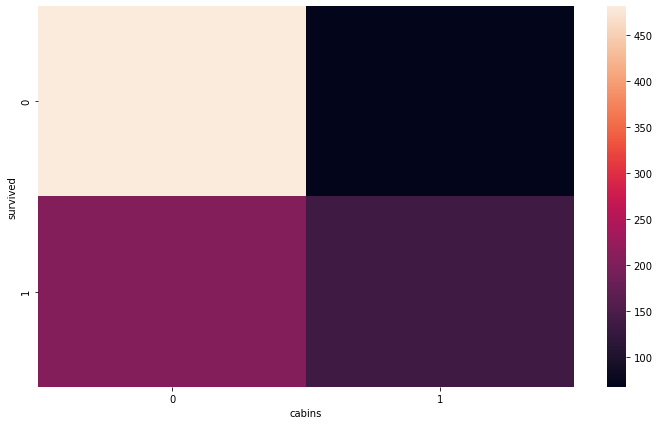

In [25]:
plt.figure(figsize=(12,7))
sns.heatmap(pd.crosstab(test_df['survived'],test_df['cabins']))

In [26]:
pd.crosstab(test_df['survived'],test_df['cabins'])

cabins,0,1
survived,,
0,481,68
1,206,136


In [27]:
data['Cabin'] = new_cabins

In [28]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket Rank,Ticket Id
617,0,3,Mrs,female,26.0,1,0,16.1000,0,S,A/5.,3336
379,0,3,Mr,male,19.0,0,0,7.7750,0,S,0,347069
725,0,3,Mr,male,20.0,0,0,8.6625,0,S,0,315094
826,0,3,Mr,male,28.0,0,0,56.4958,0,S,0,1601
450,0,2,Mr,male,36.0,1,2,27.7500,0,S,C.A.,34651


In [29]:
data,idx,labels_and_int_index,new_data = object_to_int(data,'Name')
data,idx,labels_and_int_index,new_data = object_to_int(data,'Sex')
data,idx,labels_and_int_index,new_data = object_to_int(data,'Name')
data,idx,labels_and_int_index,new_data = object_to_int(data,'Ticket Rank')
data,idx,labels_and_int_index,new_data = object_to_int(data,'Embarked')

In [30]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket Rank,Ticket Id
617,0,3,0,0,26.0,1,0,16.1000,0,0,0,3336
379,0,3,1,1,19.0,0,0,7.7750,0,0,1,347069
725,0,3,1,1,20.0,0,0,8.6625,0,0,1,315094
826,0,3,1,1,28.0,0,0,56.4958,0,0,1,1601
450,0,2,1,1,36.0,1,2,27.7500,0,0,2,34651


In [31]:
test_df = pd.DataFrame({'survived':data['Survived'],'Embarked':data['Embarked']})
pd.crosstab(test_df['survived'],test_df['Embarked'])

Embarked,0,1,2,3
survived,,,,
0,427,75,47,0
1,217,93,30,2


In [32]:
X = data.drop('Survived',axis=1)
y = data['Survived']

In [33]:
data_old = data.copy()

In [34]:
def fe(data,col):
    max_num = data[col].quantile(0.99)
    min_num = data[col].quantile(0.05)
    data = data[data[col] < max_num]
    data = data[data[col] > min_num]
    return data
for col in list(X.columns):
    try:
        data = data_old.copy()
        data = fe(data,col)
        X = data.drop('Survived',axis=1)
        y = data['Survived']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.125)
        model = GradientBoostingClassifier()
        model = train(model,X_train,X_test,y_train,y_test,name=f'{col}-fe')
    except:
        pass

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


11


val accuracy_score,1.0
val precision_score,1.0
val f1_score,1.0
val recall_score,1.0
_runtime,7
_timestamp,1629788694
_step,2
accuracy_score,1.0
precision_score,1.0
f1_score,1.0
recall_score,1.0


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,0.929
val precision_score,0.92188
val f1_score,0.88279
val recall_score,0.84689
_runtime,8
_timestamp,1629788727
_step,2
accuracy_score,0.81053
precision_score,0.7619
f1_score,0.64
recall_score,0.55172


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,0.91484
val precision_score,0.93004
val f1_score,0.87938
val recall_score,0.83395
_runtime,11
_timestamp,1629788748
_step,2
accuracy_score,0.85714
precision_score,0.80556
f1_score,0.79452
recall_score,0.78378


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,0.98734
val precision_score,1.0
val f1_score,0.98712
val recall_score,0.97458
_runtime,8
_timestamp,1629788772
_step,2
accuracy_score,0.85294
precision_score,0.8
f1_score,0.82759
recall_score,0.85714


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,1.0
val precision_score,1.0
val f1_score,1.0
val recall_score,1.0
_runtime,9
_timestamp,1629788794
_step,2
accuracy_score,0.80769
precision_score,0.8125
f1_score,0.83871
recall_score,0.86667


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,0.9018
val precision_score,0.92941
val f1_score,0.86972
val recall_score,0.81724
_runtime,8
_timestamp,1629788818
_step,2
accuracy_score,0.84615
precision_score,0.82857
f1_score,0.78378
recall_score,0.74359


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,1.0
val precision_score,1.0
val f1_score,1.0
val recall_score,1.0
_runtime,7
_timestamp,1629788843
_step,2
accuracy_score,0.7619
precision_score,0.9
f1_score,0.78261
recall_score,0.69231


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


val accuracy_score,0.99462
val precision_score,1.0
val f1_score,0.9932
val recall_score,0.98649
_runtime,7
_timestamp,1629788865
_step,2
accuracy_score,0.88889
precision_score,0.8
f1_score,0.84211
recall_score,0.88889


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11


In [35]:
X.isna().sum()

Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Ticket Rank    0
Ticket Id      0
dtype: int64

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.125)

In [37]:
# model = CatBoostClassifier()
# train(model,X_train,X_test,y_train,y_test,name='test')

In [38]:
# 0 = not survived
# 1 = survived
# 1 = has a cabin
# 0 = has no cabin

In [39]:
do_le = False

In [40]:
X_train_old,X_test_old,y_train_old,y_test_old  = X_train.copy(),X_test.copy(),y_train.copy(),y_test.copy()

In [41]:
# pres = [    StandardScaler,
#     RobustScaler,
#     MinMaxScaler,
#     MaxAbsScaler,
#     Normalizer,]
# for pre in pres:
#     X_train,X_test,y_train,y_test  = X_train_old.copy(),X_test_old.copy(),y_train_old.copy(),y_test_old.copy()
#     if do_le:
#         le = LabelEncoder()
#     pre = pre()
#     pre.fit(X)
#     X_train = pre.fit_transform(X_train)
#     X_test = pre.transform(X_test)
#     if do_le:
#         le = le
#         y_train = le.fit_transform(y_train)
#         y_test = le.transform(y_test)
#     model = GradientBoostingClassifier()
#     train(model,X_train,X_test,y_train,y_test,name=f'{pre}-{do_le}')

In [42]:
# le = LabelEncoder()

In [43]:
# le = le
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [44]:
model = GradientBoostingClassifier()
model = train(model,X_train,X_test,y_train,y_test,name=f'le only')

val accuracy_score,0.9235
val precision_score,0.94444
val f1_score,0.89474
val recall_score,0.85
_runtime,8
_timestamp,1629788889
_step,2
accuracy_score,0.8381
precision_score,0.84615
f1_score,0.79518
recall_score,0.75


val accuracy_score,▁
val precision_score,▁
val f1_score,▁
val recall_score,▁
_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█
accuracy_score,▁
precision_score,▁
f1_score,▁
recall_score,▁


11
